In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
import torchvision.models as torch_models

import io
import json
import base64
from PIL import Image

In [2]:
# dataset

cat_path = '../json_data/cat.json'
with open(cat_path, 'r') as f:
    cat_json = json.load(f)
    
print(type(cat_json))
for key in cat_json.keys():
    print(key, ': ', len(cat_json[key]))

<class 'dict'>
image_base64_string :  1000
label :  1000


## Read Data

In [3]:
cat_df = pd.DataFrame.from_dict(cat_json)
print(cat_df.head())

                                 image_base64_string  label
0  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAoHBwgHBgoICA...      0
1  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAoHBwgHBgoICA...      1
2  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAoHBwgHBgoICA...      0
3  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAoHBwgHBgoICA...      0
4  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAoHBwgHBgoICA...      1


In [4]:
# print(cat_df.iloc[0].at['image_base64_string'])

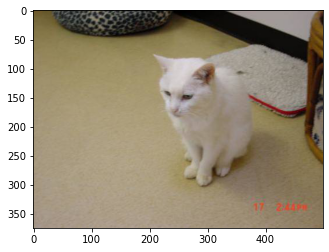

In [5]:
img = base64.b64decode(cat_df.iloc[0].at['image_base64_string'])
img = Image.open(io.BytesIO(img))
plt.imshow(img)

In [6]:
img_np = np.array(img)
print(img_np.shape)

(375, 499, 3)


## Model

In [7]:
class VGG(nn.Module):
    """
    VGG builder
    """

    def __init__(self, arch: object, num_classes=1000) -> object:
        super(VGG, self).__init__()
        self.in_channels = 3
        self.conv3_64 = self.__make_layer(64, arch[0])
        self.conv3_128 = self.__make_layer(128, arch[1])
        self.conv3_256 = self.__make_layer(256, arch[2])
        self.conv3_512a = self.__make_layer(512, arch[3])
        self.conv3_512b = self.__make_layer(512, arch[4])
        self.fc1 = nn.Linear(7 * 7 * 512, 4096)
        self.bn1 = nn.BatchNorm1d(4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.bn2 = nn.BatchNorm1d(4096)
        self.fc3 = nn.Linear(4096, num_classes)

    def __make_layer(self, channels, num):
        layers = []
        for i in range(num):
            layers.append(nn.Conv2d(self.in_channels, channels, 3, stride=1, padding=1, bias=True))  # same padding
            layers.append(nn.BatchNorm2d(channels))
            layers.append(nn.ReLU())
            self.in_channels = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv3_64(x)
        out = F.max_pool2d(out, 2)
        out = self.conv3_128(out)
        out = F.max_pool2d(out, 2)
        out = self.conv3_256(out)
        out = F.max_pool2d(out, 2)
        out = self.conv3_512a(out)
        out = F.max_pool2d(out, 2)
        out = self.conv3_512b(out)
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        # out = self.bn1(out)
        out = F.relu(out)
        out = self.fc2(out)
        # out = self.bn2(out)
        out = F.relu(out)
        # return F.softmax(self.fc3(out))
        return self.fc3(out)


def VGG_11(num_classes = 1000, pretrained = False):
    Net = VGG([1, 1, 2, 2, 2], num_classes)
    if pretrained == True:
        pass
    return Net


def VGG_13(num_classes = 1000, pretrained = False):
    Net = VGG([2, 2, 2, 2, 2], num_classes)
    if pretrained == True:
        pass
    return Net


def VGG_16(num_classes = 1000, pretrained = False):
    Net = VGG([2, 2, 3, 3, 3], num_classes)
    if pretrained == True:
        pass
    return Net


def VGG_19(num_classes = 1000, pretrained = False):
    Net = VGG([2, 2, 4, 4, 4], num_classes)
    if pretrained == True:
        weights_dict = VGG19_bn_Weights(Net)
        Net.load_state_dict(weights_dict)
    return Net

def set_device(Net):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # set for multi device
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)

    Net = Net.to(device)
    return Net

def VGG_test(net):
    input_shape = (10, 3, 224, 224)
    print('input_shape = ', input_shape)
    print(summary(net, input_shape))
    
def VGG19_bn_Weights(VGG):
    # load pretrain weight, need download at first use
    torch_vgg = torch_models.vgg19_bn(pretrained=True)

    # get dict key
    vgg_list = list(VGG.state_dict().keys())
    torch_vgg_list = list(torch_vgg.state_dict().keys())

    # get weight from torch
    new_dict = {}
    for i in range(len(torch_vgg_list[:-6])):
        # print(vgg_list[i], torch_vgg_list[i])
        new_dict[vgg_list[i]] = torch_vgg.state_dict()[torch_vgg_list[i]]
        new_dict[vgg_list[i]].requires_grad = False

    # update VGG weight
    old_dict = VGG.state_dict()
    for i in range(len(vgg_list)):
        key = vgg_list[i]
        if key in old_dict and key in new_dict:
            old_dict[key] = new_dict[key]
    
    return old_dict

In [8]:
net = VGG_11(num_classes=2, pretrained = True)
net = set_device(net)
VGG_test(net)

input_shape =  (10, 3, 224, 224)
Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      --                        --
├─Sequential: 1-1                        [10, 64, 224, 224]        --
│    └─Conv2d: 2-1                       [10, 64, 224, 224]        1,792
│    └─BatchNorm2d: 2-2                  [10, 64, 224, 224]        128
│    └─ReLU: 2-3                         [10, 64, 224, 224]        --
├─Sequential: 1-2                        [10, 128, 112, 112]       --
│    └─Conv2d: 2-4                       [10, 128, 112, 112]       73,856
│    └─BatchNorm2d: 2-5                  [10, 128, 112, 112]       256
│    └─ReLU: 2-6                         [10, 128, 112, 112]       --
├─Sequential: 1-3                        [10, 256, 56, 56]         --
│    └─Conv2d: 2-7                       [10, 256, 56, 56]         295,168
│    └─BatchNorm2d: 2-8                  [10, 256, 56, 56]         512
│    └─ReLU: 2-9                     

In [17]:
# # helper function for classification

def calc_acc(out, labels):
    num = out.size(0)
    prediction = out.argmax(dim=1)
    return (prediction == labels).sum().item()/num

def evaluate(model, loss_func, dataloader, method='classification'):
    loss = 0
    acc = 0

    loss = []
    acc = []
    
    model, torch_device = set_device(model)
    
    for step, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.to(torch_device)
        labels = labels.to(torch_device)

        out = model(inputs)
        loss.append(loss_func(out, labels))
        
        if method == 'classificaiton':
            acc.append(calc_acc(out, labels))

    loss = torch.mean(torch.tensor(loss))
    
    if method == 'classificaiton':
        acc = torch.mean(torch.tensor(acc))
        return loss, acc
    elif method == 'regression':
        return loss


In [18]:
# Define a train function

def train_model(model, train_dataset, test_dataset, batch = 256, epochs=50,
                lr=0.005, class_weights = None, weight_decay = 0):

    # train_history
    train_history = {}
    train_history['train_loss'] = []
    train_history['train_acc'] = []

    train_history['test_loss'] = []
    train_history['test_acc'] = []

    # set device
    model, torch_device = set_device(model)
    
    if class_weights != None:
        class_weights = class_weights.to(device)

    # Dataloader
    train_dl = DataLoader(train_dataset, batch_size=batch, shuffle=True)
    test_dl = DataLoader(test_dataset, batch_size=batch, shuffle=True)
    
    # optimzer and loss_func
    optimzer = torch.optim.Adam(model.parameters(), lr=0.005, betas=(0.9, 0.999), eps=1e-08, weight_decay=weight_decay, amsgrad=False)
    loss_func = nn.CrossEntropyLoss(weight = class_weights)

    # train_process
    for epoch in range(epochs):
        
        for step, (inputs, labels) in enumerate(train_dl):
            inputs = inputs.to(torch_device)
            labels = labels.to(torch_device)

            out = model(inputs)
            loss = loss_func(out, labels)
            optimzer.zero_grad()
            loss.backward()
            optimzer.step()

            # output
            train_loss, train_acc = evaluate(model, loss_func, train_dl)
            test_loss, test_acc = evaluate(model, loss_func, test_dl)

            print(  'Epoch:', epoch+1, '/', epochs, ', '\
                    'train_loss: {loss:.5f}, '.format(loss = train_loss), \
                    'train_acc: {acc:.5f}, '.format(acc = train_acc), \
                    'test_loss: {loss:.5f}, '.format(loss = test_loss), \
                    'test_acc: {acc:.5f}'.format(acc = test_acc))

            train_history['train_loss'].append(train_loss)
            train_history['train_acc'].append(train_acc)

            train_history['test_loss'].append(test_loss)
            train_history['test_acc'].append(test_acc)
  
    return train_history

In [19]:
# device

def set_device(net, device='GPU'):
    if device == 'GPU':
        torch_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    else:
        torch_device = torch.device("cpu")

    if torch.cuda.device_count() > 1:
        model = nn.DataRarallel(model)

    net = net.to(torch_device)
    return net, torch_device

In [20]:
train_dataset = dataset(x_train, y_train)
test_dataset = dataset(x_test, y_test)

batch = 10000
epochs = 50
lr = 0.005

NameError: name 'dataset' is not defined

In [ ]:
"""
Train Model
"""

# load model
model = boston_model(13, 1)
print(summary(model, (500, 13)))

# train
hist = train_model(model, train_dataset, test_dataset, batch, epochs, lr)